This is a jupyter notebook to demonstrate the functionality of the heron-BBH binary black hole surrogate model.
The surrogate model is conditioned on numerical relativity data produced by the Georgia Tech group.

In [1]:
import heron
from heron import waveform
from george import kernels
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/daniel/papers/thesis/thesis-style.mpl")

In [3]:
from matplotlib import rc, font_manager
lato = {'family': 'Lato',
        'color':  'black',
        'weight': 'light',
        'size': 10,
        }
ssp_ticks = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 6,
        }
ssp_legend = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 8,
        }
ticks_font = font_manager.FontProperties(**ssp_ticks)

In [4]:
import elk
print(elk.__version__)
import elk.catalogue

0+untagged.20.g259af60.dirty


In [5]:
import pycbc

In [6]:
import pycbc.psd

In [7]:
total_mass = 60

In [24]:
catalogue = elk.catalogue.NRCatalogue(origin="GeorgiaTech")

imr_cat = elk.catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo_cat = elk.catalogue.PPCatalogue("SEOBNRv4_ROM", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo3_cat = elk.catalogue.PPCatalogue("SEOBNRv3", 
                                    total_mass=10, 
                                    fmin=95)
nrsur_cat = elk.catalogue.PPCatalogue("NRSur7dq2", 
                                    total_mass=10, 
                                    fmin=95)

In [25]:
p = {"mass ratio": 1,
                 "spin 1x": 0., "spin 1y": 0., "spin 1z": 0.,
                 "spin 2x": 0., "spin 2y": 0., "spin 2z": 0.}
seo3_cat.waveform(p=p, time_range=[-150.,100.,1024.])

(<elk.waveform.Timeseries at 0x7f1c685e28d0>,
 <elk.waveform.Timeseries at 0x7f1c6865f0d0>)

In [ ]:
additional = [
   {"name": "Non-spinning",
    "label": "Figure 2",
    "color": "#348ABD",
    "mass_ratio": 1, 
    "spin_1x": 0, "spin_1y": 0, "spin_1z": 0,
    "spin_2x": 0, "spin_2y": 0, "spin_2z": 0},
    {"name": "Spinning",
    "label": "Figure 3",
     "color": "#988ED5",
    "mass_ratio": 1, 
    "spin_1x": 0, "spin_1y": 0, "spin_1z": 0.6,
    "spin_2x": 0, "spin_2y": 0, "spin_2z": -0.6},
    {"mass_ratio": .5,
     "name": "Precessing",
     "label": "Figure 4",
     "color": "#FBC15E",
    "spin_1x": 0.35, "spin_1y": 0.1, "spin_1z": 0.2,
    "spin_2x": 0, "spin_2y": 0, "spin_2z": 0.4},
    {"mass_ratio": .25,
     "name": "Poor",
     "label": "Figure 5",
     "color": "#FFB5B8",
                 "spin_1x": 0.4, "spin_1y": 0.1, "spin_1z": 0.425,
                 "spin_2x": 0, "spin_2y": 0.3, "spin_2z": 0.6}
]


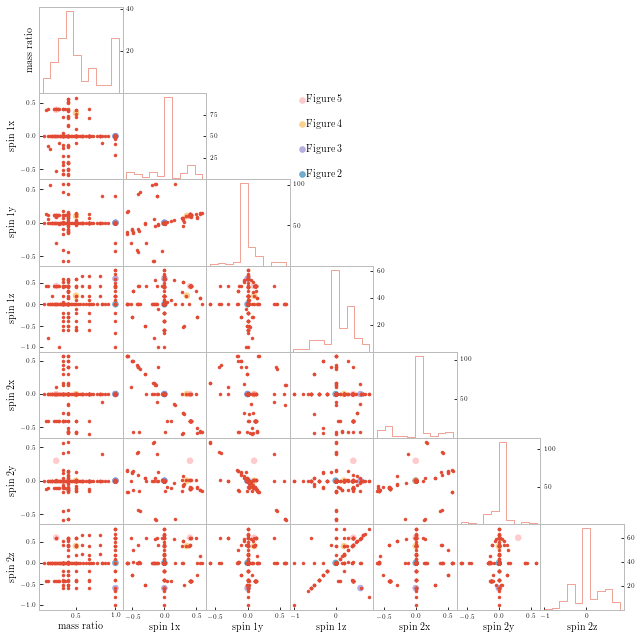

In [12]:

f = catalogue.coverage_plot(additional=additional)

for ax in f.axes:
    
    ax.set_ylabel(ax.get_ylabel(), fontdict=lato)
    ax.set_xlabel(ax.get_xlabel(), fontdict=lato)
    
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)

In [9]:
f.savefig("coverage.pdf")

Define the Gaussian process model. There are separate kernel terms for the time axis, the mass axis, and each of the spin axes. These are all initialised with plausible length-scales.

This is used to build a `heron` Gaussian process 'catalogue', which is the interpolation object.

For this scenario the GPR is trained with waveforms sampled at 1,024-Hz, a minimum frequency of 95-Hz (which is chosen to allow all but one of the NR waveforms to be included in the training set), and a total CBC system mass of 60 solar masses.

A small quantity (with amplitude 1e-8) is added to the kernel to improve the numerical stability of the algorithm, and the HODLR matrix solver is used.

In [18]:
problem_dims = 8
c_ind = catalogue.c_ind
time_covariance = kernels.ExpSquaredKernel(50,
#kernels.RationalQuadraticKernel(.05, 400,
                                           ndim=problem_dims,
                                           axes=c_ind['time'],)
mass_covariance = kernels.ExpSquaredKernel(0.005, #0.09
#mass_covariance = kernels.Matern52Kernel(0.005, #0.09
                                           ndim=problem_dims,
                                           axes=c_ind['mass ratio'])
spin_covariance = kernels.ExpSquaredKernel([0.005, 0.005, 0.005, 
#spin_covariance = kernels.Matern52Kernel([0.005, 0.005, 0.005, 
                                            0.005, 0.005, 0.005], 
                                           ndim=problem_dims, 
                                           axes=[2,3,4,5,6,7])

covariance =  1e1 * mass_covariance * time_covariance * spin_covariance

gp = gp_cat = waveform.GPCatalogue(catalogue, covariance,
                                   total_mass=total_mass, fsample=1024,
                                   mean=0.0,
                                   ma=[(2,2)],
                                   solver="hodlr",
                                   tmax=0.02,
                                   white_noise=1e-10,)

There was an error producing a waveform for GT0392
Computing


We define a function to produce inspection plots which naively compare samples from the GPR to two different waveform approximant models.

In [19]:
def sample_plot(p, surrogates=True, phase_shift=(0,0)):
    """
    Make a plot to compare sample draws from the GPR to SEOBNRv4 and 
    IMRPhenomPv2.
    """
    samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150, 200, 1024], samples=100)
    
    if surrogates:
        imr = imr_cat.waveform(p=p,
                            time_range=[-150., 200., 1024],
                              coa_phase=phase_shift[0],
                              )
        
        imr[0].times -= imr[0].times[np.argmax(np.abs(imr[0].data - 1j * imr[1].data))]
        imr[1].times -= imr[1].times[np.argmax(np.abs(imr[0].data - 1j * imr[1].data))]
        
        #imr[0].times -= imr[0].times[np.argmax(imr[0].data)]
        #seo = seo_cat.waveform(p=p,
        #                time_range=[-150., 100., 1024],
        #                      coa_phase=phase_shift[1],)
        #seo[0].times -= seo[0].times[np.argmax(seo[0].data)]
    width = 4.5
    height = width/1.618
    f, ax = plt.subplots(1,1, figsize=(2*width, height), dpi=300);
    mean, var = gp_cat.waveform(p=p, time_range= [-150, 200, 1024])
    times = np.linspace(-.0150,.0200, 1024)
    #times -= times[np.argmax(mean)]
    waveforms = []
    for sample in samples:
        #sample.times -= sample.times[np.argmax(mean)]
        ax.plot(sample.times, sample.data, alpha=0.05, color='k');
        waveforms.append(sample.data)

    #mean = np.array(waveforms).mean(axis=0)
    
    ax.plot(times, mean.data, color="#7e25aa", label="GPR Mean")
        
    if surrogates:
        ax.plot(imr[0].times, imr[0].data, label="IMRPhenomPv2");
        #ax.plot(seo[0].times, seo[0].data, label="SEOBNRv3");
        
    ax.set_xlabel("Times [sec] from merger", fontdict=lato);
    ax.set_ylabel("Strain (h+)", fontdict=lato);

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    ax.yaxis.get_offset_text().set_fontproperties(ticks_font)
     
    #ax.plot(imr[0].times*1e4, 1024*mean/1e16, color="#7e25aa", label="GPR Mean")
    
    ax.legend(prop=ssp_legend);
    
    return f, ax

In [20]:
# After 2000 training iterations with ADAM
gp_cat.gp.set_parameter_vector(np.log([1.33e+00,
                                       2.04e-04,
                                       95,
                                       8.78725810e-04, 7.28872939e-04, 6.98418530e-04,
                                       8.91739716e-04, 7.28836193e-04, 7.05170046e-04]))

In [21]:
def match(a, b, psd=None):
    
    data_a = a.pycbc()
    data_b = b.pycbc()
    
    if psd == "aligo":
        f_low = 5
        f_delta = 1./16
        flen = int(2048/ f_delta) + 1
        psd = pycbc.psd.aLIGOZeroDetHighPower(flen, f_delta, f_low)
    
        return pycbc.filter.match(data_a, data_b, psd=psd)
    
    else:
        return pycbc.filter.match(data_a, data_b)

In [22]:
import matplotlib.gridspec as gridspec
def paper_plot(p, phases=None, approximants=["IMRPhenomPv2", "SEOBNRv4"], matches_flag=True):
    width = 4.5
    height = width/1.618

    f = plt.figure(constrained_layout=True, figsize=(2 * width, height))#, dpi=500)

    gs = gridspec.GridSpec(1,4, figure = f)

        # Set up the approximants
    if "SEOBNRv4" in approximants:
        ts_seo = seo_cat.waveform(p=p, time_range=[-150., 100., 1024])
    if "IMRPhenomPv2" in approximants:
        ts_imr = imr_cat.waveform(p=p, time_range=[-150., 100., 1024])
    
    samples = gp_cat.waveform_samples(p=p,
                                  time_range=[-150., 100., 1024], samples=100)
    mean, variance = gp_cat.waveform(p=p, time_range=[-150.,100.,1024])
    
    
    if "IMRPhenomPv2" in approximants:
            matchimr, phaseimr = match(mean, ts_imr[0])
    if "SEOBNRv4" in approximants:
            matchseo, phaseseo = match(mean, ts_seo[0])
    
    
    # Waveform plot
    times = samples[0].times #np.linspace(-150, 100, 1024)/1e4
    #std = np.array(waveforms).std(axis=0)
    ax_wave = f.add_subplot(gs[0:3])
    ax_hist = f.add_subplot(gs[3])
    for sample in samples[1:]:
        ax_wave.plot(sample.times, sample.data, color='k', alpha=0.0525, lw=0.5)
    ax_wave.plot(samples[0].times, samples[0].data, color='k', alpha=0.0525, lw=0.5, label="GPR Draws")
    ax_wave.plot(times, mean.data, label = "GPR Mean", 
                 linestyle="--",
                 alpha=0.5, color='k', lw=2)
    ax_wave.fill_between(times, (mean.data+(variance.data)), (mean.data-(variance.data)), alpha=0.1, color='k', label="GPR Variance")


            
    ax_wave.legend(prop=ssp_legend)

    #ax_wave.set_xlim([-0.01, 0.01])

    imr_matches = []
    seo_matches = []
    
    if matches_flag:
        for sample in samples:
            if "IMRPhenomPv2" in approximants:
                ma = match(sample, ts_imr[0])
                imr_matches.append(ma[0])
                
            if "SEOBNRv4" in approximants:
                seo_matches.append(match(sample, ts_seo[0])[0])

        if "IMRPhenomPv2" in approximants:
            ax_hist.hist(1.0 - np.array(imr_matches), 
                         range=(0,.25), 
                         density=True,
                         bins=21, 
                         histtype="stepfilled", 
                         alpha=0.4,
                         color="#348ABD",
                         label="IMRPhenomPv2"
                        )

        if "SEOBNRv4" in approximants:
            ax_hist.hist(1.0 - np.array(seo_matches), 
                     range=(0,.25), 
                     density=True,
                     bins=21, 
                     histtype="stepfilled", 
                     alpha=0.4,
                     color="#E24A33",
                     label="SEOBNRv4"
                    )
        ax_hist.legend(prop=ssp_legend)
        #ax_hist.vlines(x=[1-mean_match_imr, 1-mean_match_seo], ymax=35, ymin=0,
        #              color=['blue', 'red'])

        if "IMRPhenomPv2" in approximants:
            ax_hist.vlines(1.-matchimr/100., *ax_hist.get_ylim(), color="#348ABD")
        if "SEOBNRv4" in approximants:
            ax_hist.vlines(1.-matchseo/100., *ax_hist.get_ylim(), color="#E24A33")
        ax_wave.set_xlabel("Time since merger [s]", fontdict=lato)
        ax_hist.set_xlabel("Mismatch", fontdict=lato)
        ax_wave.set_ylabel("Strain", fontdict=lato)
        
    if "SEOBNRv4" in approximants:
        ts_seo = seo_cat.waveform(p=p, time_range=[-250.,200.,2048])
    if "IMRPhenomPv2" in approximants:
        ts_imr = imr_cat.waveform(p=p, time_range=[-250.,200.,2048])
    
    mean, variance = gp_cat.waveform(p=p, time_range=[-250.,200.,2048])
    if "IMRPhenomPv2" in approximants:
        # IMRPhenomPv2
        waveform_imr = ts_imr[0]#(coa_phase=0, t0=0)[0]
        a, b = pycbc.waveform.coalign_waveforms(ts_imr[0].pycbc(), mean.pycbc())
        
        ax_wave.plot((a.sample_times+mean.times[0])/1e4, a, label="IMRPhenomPv2", 
                     lw=2, alpha=0.8, color="#348ABD")
    if "SEOBNRv4" in approximants:
        # SEOBNRv4
        a, b = pycbc.waveform.coalign_waveforms(ts_seo[0].pycbc(), mean.pycbc())
        ax_wave.plot((a.sample_times+mean.times[0])/1e4, a, label="SEOBNRv4", 
                     lw=2, alpha=0.8, color="#E24A33")
    
    ax_wave.set_xlim([-0.01, 0.01])
    
    for label in ax_wave.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax_wave.get_yticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax_hist.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax_hist.get_yticklabels():
        label.set_fontproperties(ticks_font)
    ax_hist.xaxis.get_offset_text().set_fontproperties(ticks_font)
    
    ax_hist.yaxis.get_offset_text().set_fontproperties(ticks_font)
    ax_wave.xaxis.get_offset_text().set_fontproperties(ticks_font)
    
    ax_wave.yaxis.get_offset_text().set_fontproperties(ticks_font)
    #f.tight_layout()
    
    return f, [ax_wave, ax_hist], #{"imr": {"phase": phaseimr}, "seo": {"phase": phaseseo}}



In [190]:
p = {"mass ratio": 1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0}

(50, 41)


(<Figure size 648x200.247 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f5bb06e7b10>])

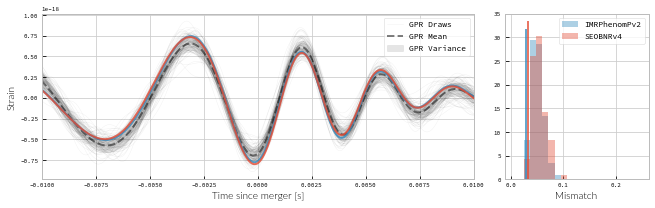

In [191]:
paper_plot(p)

In [192]:
p = {"mass ratio": 1,
                 "spin 1x": 0, "spin 1y": 0, "spin 1z": 0.6,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": -0.6}

(40, 31)


(<Figure size 648x200.247 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f5bb045b150>])

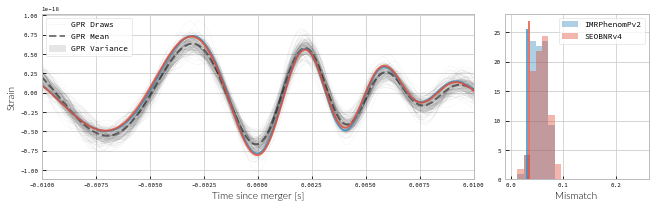

In [193]:
paper_plot(p)

In [26]:
p = {"mass ratio": .5,
                 "spin 1x": 0.35, "spin 1y": 0.1, "spin 1z": 0.2,
                 "spin 2x": 0, "spin 2y": 0, "spin 2z": 0.4}

(<Figure size 648x200.247 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f832e8eaa10>])

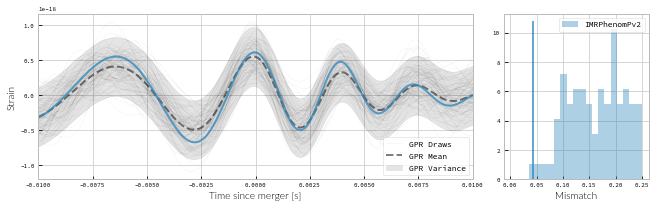

In [27]:
paper_plot(p, approximants=["IMRPhenomPv2"])

In [ ]:
p = {"mass ratio": .25,
                 "spin 1x": 0.4, "spin 1y": 0.1, "spin 1z": 0.425,
                 "spin 2x": 0, "spin 2y": 0.3, "spin 2z": 0.6}
paper_plot(p, approximants=["IMRPhenomPv2"])

## Quick tests on the length scale

In [17]:
gp_cat.gp.set_parameter_vector(np.log([1.33e+00,
                                       2.04e-04,
                                       95,
                                       8.78725810e-04, 7.28872939e-04, 6.98418530e-04,
                                       8.91739716e-04, 7.28836193e-04, 7.05170046e-04]))
p = {"mass ratio": .25,
                 "spin 1x": 0.4, "spin 1y": 0.1, "spin 1z": 0.425,
                 "spin 2x": 0, "spin 2y": 0.3, "spin 2z": 0.6}
paper_plot(p, approximants=["IMRPhenomPv2"])

NameError: name 'gp_cat' is not defined

In [13]:
def plot_planes(ranges, fixed):
    """
    Produce a plot of the waveform predictions from
    the GP.

    Parameters
    ----------
    ranges : dict
       A dictionary in which the keys are the name of the parameter
       and the values are a list in the format [start, end, npoints]
       at which the GP should be evaluated for the plane.
    fixed : dict
       A dictionary in which the keys are the name of the parameter
       which should be fixed, and the value is the fixed value of 
       that parameter.
    """

    mean, var = gp_cat.mean(ranges, fixed)

    ranges_x = list(ranges.items())[0][1]
    ranges_y = list(ranges.items())[1][1]

    f, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    im = ax.imshow(mean, origin="lower", cmap = "magma",# vmin=-3, vmax=3,
                   extent = (ranges_x[0], ranges_x[1], ranges_y[0], ranges_y[1]),
                   aspect = ( (ranges_x[1] - ranges_x[0])
                              / (ranges_y[1] - ranges_y[0] )))
    cax = f.add_axes([0.9, 0.1, 0.02, 0.8])
    cax.yaxis.get_offset_text().set_fontproperties(ticks_font)
    f.colorbar(im, cax=cax, orientation='vertical')

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    ax.set_ylabel("Time [ms]",  fontdict=lato)
    ax.set_xlabel(list(ranges.keys())[0],  fontdict=lato)

    g, ax = plt.subplots(1,1, figsize=(6, 6/1.6), dpi=300)
    im = ax.imshow(np.abs(var), origin="lower",
                   cmap = "viridis",
                   extent = (ranges_x[0], ranges_x[1], ranges_y[0], ranges_y[1]),
                   aspect = ( (ranges_x[1] - ranges_x[0])
                              / (ranges_y[1] - ranges_y[0] )))

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    cax = g.add_axes([0.9, 0.1, 0.02, 0.8])
    cax.yaxis.get_offset_text().set_fontproperties(ticks_font)
    g.colorbar(im, cax=cax, orientation='vertical')

    for label in cax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    
    ax.set_ylabel("Time [ms]", fontdict=lato)
    ax.set_xlabel(list(ranges.keys())[0],  fontdict=lato)

    return f, g

In [15]:
f, g = plot_planes(ranges={"time": [-150, 100, 200], "mass ratio": [0.1, 1.0, 10]}, fixed = {"spin 1x": 0, "spin 1y": 0, "spin 1z": 0, "spin 2x": 0, "spin 2y": 0, "spin 2z": 0})

MemoryError: std::bad_alloc

In [38]:
g.savefig("massratio-variance.pdf")